In [3]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [4]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [5]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [6]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
    for wavelength in [1.64, 2.13]:
        sensors_dict.add_sensor('MODIS',
        at3d.sensor.orthographic_projection(wavelength, 
                                            rte_grid, 
                                            sensor_resolution, 
                                            sensor_resolution,
                                            azimuth, zenith,
                                            altitude='TOA', stokes=['I'])
                            )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [7]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [8]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [9]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 3.301307
cloud OD @ 1.640 nm = 3.3963447
cloud OD @ 2.130 nm = 3.4415367


In [10]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [11]:
sensors_dict.get_measurements(solvers, n_jobs=8)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.555  0.272E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     1  -0.652  0.355E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     1  -0.607  0.324E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     2  -1.012  0.321E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     2  -1.309  0.397E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     2  -1.110  0.370E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     3  -1.431  0.349E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     3  -1.482  0.393E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     3  -1.637  0.413E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     4  -1.671  0.293E+00    30817    16.10  0.252   [Radiance 2.130 micron]
     4  

In [12]:
def retrieve(uncertainty = 6e9, scale = 1.5e2):
    Sensordict = sensors_dict
    uncertainty = at3d.uncertainties.NullUncertainty('L2', uncertainty)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
                #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    Sensordict.add_uncertainty_model('MISR', uncertainty)
    # uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
    # Sensordict.add_uncertainty_model('MISR', uncertainty)
    # Sensordict.add_noise('MISR')
    # Sensordict.add_uncertainty_model('MODIS', uncertainty)
    # Sensordict.add_noise('MODIS')
    forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

    scale_reff = scale
    #scale_aerosol_density = 1e4

    wavelengths = forward_sensors.get_unique_solvers()

    mask = solvers[0.66].medium['cloud'].extinction.data > 0.0

    ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
    CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
    CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
    print(CBH, CTH)
    initial_cloud = xr.Dataset(
        data_vars={
            'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
            'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
            'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
        },
        coords=rte_grid.coords
    )

    #resample the cloud onto the rte_grid
    initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
    reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

    def state_to_grid_density_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[mask] = state[1:]
        return state_on_grid

    def state_to_grid_reff_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    solvers_reconstruct = at3d.containers.SolversDict()
    rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

    def set_state_fn(state):

        #update microphysics
        #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
        cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

        cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
        cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
        #update optical properties
        for wavelength in wavelengths:
            poly_table = cloud_poly_tables[wavelength] #tables are used here.
            cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
            #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
            
            #aerosol_poly_table = aerosol_poly_tables[wavelength]
            #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
            #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

    #         config = at3d.configuration.get_config('./default_config.json')
    #         config['num_mu_bins'] = 2
    #         config['num_phi_bins'] = 4
    #         config['split_accuracy'] = 0.1
    #         config['spherical_harmonics_accuracy'] = 0.001
    #         config['solution_accuracy'] = 1e-5
            solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                    numerical_params=solvers[wavelength].numerical_params,#config,
                                                    medium={'cloud': cloud_optical_scatterer,
                                                        'rayleigh': rayleigh_scatterer_list[wavelength]
                                                        },
                                                    source=solvers[wavelength].source,
                                                    surface=solvers[wavelength].surface,
                                                    num_stokes=solvers[wavelength]._nstokes,
                                                    name=None
                                                    )
                                    )

    # unknown_scatterers = at3d.containers.UnknownScatterers()
    # unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
    # unknown_scatterers.create_derivative_tables()

    mie_mono_tables = OrderedDict()
    for wavelength in wavelengths:
        mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
            'Water',(wavelength,wavelength),
            max_integration_radius=65.0,
            minimum_effective_radius=0.1,
            relative_dir='../mie_tables',
            verbose=False
        )

    optical_property_generator = at3d.medium.OpticalPropertyGenerator(
        'cloud', 
        mie_mono_tables,
        at3d.size_distribution.gamma,
        density_normalization='geometric_extinction',
        reff=np.linspace(.1,30.0,30),
        veff=np.linspace(0.03,0.2,9),
    )

    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, cloud_optical_scatterer
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
            reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
            density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
        #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
        )
    )

    def project_gradient_to_state(state, gradient):
        cloud_gradient = gradient.gradient.sel(variable_name='density',
                                            scatterer_name='cloud').data[mask]

        reff_gradient = gradient.gradient.sel(variable_name='reff',
                                            scatterer_name='cloud').where(mask, np.nan)
        
        reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
        #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

        full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
        
        #print some things here because I'm lazy.
        print('reff', state[0]/scale_reff , full_grad[0])
        print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
        print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
        print('reff profile true', reff_profile_true)
        return full_grad

    min_bound = np.zeros(1+np.sum(mask))+1e-5
    min_bound[0] = 1e-4*scale_reff

    max_bound = np.zeros(1+np.sum(mask))+199
    max_bound[0] = 29.9*scale_reff

    obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        Sensordict, 
        solvers_reconstruct,
        forward_sensors,
        unknown_scatterers,
        set_state_fn,
        project_gradient_to_state,
        #exact_single_scatter=False,
        parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                    'verbose':False, 'maxiter':100, 'init_solution':True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bound,
        max_bounds=max_bound
    )

    # initial guess
    x0_reff = 10
    x0_ext_cloud = 10
    x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
    print(x0)
    print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))
    optimizer = at3d.optimize.Optimizer
    optimizer = at3d.optimize.Optimizer
    optimizer.options

    #define optimizer (no prior function)
    optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
    optimizer._options['maxls'] = 8
    optimizer._options['maxiter'] = 20 #maxiter to 1 to debug the saving of result.
    #optimize for the specified initial condition.
    result = optimizer.minimize(x0)
    return solvers_reconstruct[.66].medium['cloud'].reff.data.max(), np.nanmean(solvers_reconstruct[.66].medium['cloud'].density.data[mask])

In [13]:
uncertainties = np.exp(np.arange(-1, 1, .5))*4144405980.0
print(uncertainties)
scales = np.exp(np.arange(-.5, 2, .5))*9
print(scales)

[1.52464176e+09 2.51370929e+09 4.14440598e+09 6.83297029e+09]
[ 5.45877594  9.         14.83849144 24.46453646 40.33520163]


1 out of 20
------uncertainty 1524641755.9099839 scale 5.458775937413701 -------
0.56 1.4


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/gradient.py:110: UserWarning: No uncertainty model supplied for instrument 'MODIS'. Using at3d.uncertainties.NullUncertainty which isequivalent to unweighted least squares.
  warnings.warn(


[54.58775937 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 435.1655398759357
cloud density avg. 10.0 -2.078948021193409
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    n


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 23.75273996506507 29.755237306115507
cloud density avg. 19.465818432160837 -0.26958952532591457
reff profile retrieve [ 4.1         8.1233228  10.23474539 11.71585882 12.89497116 13.8906866
 14.76105714 15.53935749 16.2466456  16.89719235 17.50116844 18.06610818
 18.59776662 19.10065068 19.57836361 20.03383678 20.46949079 20.88735037
 21.28912832 21.67628796 22.05009052 22.41163167 22.76186999 23.10164948
 23.43171764 23.75273997]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 3.1360948387650573 -126.27836614412952
cloud density avg. 19.605367440529534 0.157591178059969
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 22.516314106387686 31.513434728973987
cloud density avg. 19.444749842330125 -0.2661778848959891
reff profile retrieve [ 4.1         7.70047111  9.70198564 11.10600114 12.22373593 13.16762037
 13.99268462 14.7304713  15.40094221 16.01762538 16.59016208 17.12569443
 17.6296779  18.10638482 18.55923087 18.99099482 19.40397128 19.80007959
 20.18094338 20.5479498  20.90229443 21.2450159  21.5770229  21.89911551
 22.21200229 22.51631411]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 6.768915880253171 -13.805674463885591
cloud density avg. 19.578152386463472 0.08671304588720967
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.20651909 4.42831454 4.62987334 4.81526231 4.98737986 5.14837306
 5.29988195 5.44319089 5.5793267  5.70912476 5.83327487 5.95235404
 6.06685035 6.17718082 6.28370487 6.38


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[90. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 263.94124198515556
cloud density avg. 10.0 -2.078948021193409
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

         


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 9.677729510752137 31.49636151343626
cloud density avg. 19.547923876752446 -0.06887313003884889
reff profile retrieve [4.1        4.1        4.17000724 4.77346667 5.25387989 5.65957055
 6.01419114 6.33129899 6.61947387 6.88453026 7.13061207 7.36078905
 7.57740602 7.78229927 7.97693687 8.1625132  8.34001447 8.51026565
 8.67396459 8.8317075  8.98400825 9.13131325 9.27401307 9.41245159
 9.54693335 9.67772951]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 2.5994839953235798 -79.63360329669017
cloud density avg. 19.666411626960723 0.14931629080207007
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 3.933907762210376 -20.989039005013343
cloud density avg. 19.605891075146946 0.03804587053926598
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   20    f=  1.06812D+03    |proj g|=  2.09890D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3944     20     45     30     1    20   2.099D+01   1.068D+03
  F =   1068.11991985

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[148.38491436  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 160.08845562662822
cloud density avg. 10.0 -2.078948021193409
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 3.7798224211776987 -41.82040796667478
cloud density avg. 19.605418924501034 0.10925997912550241
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  4.44205D+03    |proj g|=  4.18204D+01
reff 22.66659955257081 14.79499488226822
cloud density avg. 18.77454670369914 -0.370655412542209
reff profile retrieve [ 4.1         7.75186801  9.76674168 11.1801283  12.30532343 13.25550783
 14.08607899 14.82879003 15.50373601 16.12453524 16.70089334 17.24000011
 17.74734742 18.22723614 18.68310471 19.11775047 19.53348335 19.9322355
 20.31564136 20.68509737 21.04180708 21.38681605 21.72103904 22.04528145
 22.3602566  22.66659955]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 0.0001 5.970630361928797
cloud density avg. 19.22189701587798 -0.05362653194399888
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 3.0415159581633167 13.534208725716864
cloud density avg. 19.001889833312593 -0.07230084680922232
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 4.05488786284757 16.50866177614212
cloud density avg. 18.928585457749595 -0.07994869689013752
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[244.64536456  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 97.09855660359547
cloud density avg. 10.0 -2.078948021193409
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 1.0591952043706758 -16.986376488789357
cloud density avg. 19.650580612356684 0.029009914982797275
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  2.11676D+03    |proj g|=  1.69864D+01
reff 12.928595449668833 17.970792200527196
cloud density avg. 18.832258984777155 -0.30322610491472773
reff profile retrieve [ 4.1         4.42151745  5.57076291  6.37693164  7.01872145  7.56068849
  8.03443041  8.4580586   8.8430349   9.19712692  9.52587057  9.83336678
 10.12274799 10.39646735 10.65648607 10.90439972 11.14152581 11.36896642
 11.5876538  11.79838445 12.00184485 12.19863139 12.38926579 12.57420747
 12.75386328 12.92859545]
reff profile true [   nan    nan    nan 11.685 12.521 13.314

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[403.35201633  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 58.89325159392324
cloud density avg. 10.0 -2.078948021193409
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0459134578704834'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 3.58732208255466 -11.143496545609395
cloud density avg. 20.708110836717594 0.01111029072498778
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 0.851464885518178 -6.01773994442097
cloud density avg. 19.65148757071342 0.016281747929618954
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 2.219393484036419 -8.827371580039427
cloud density avg. 20.179799203715504 0.020907524719535817
reff profile retrieve [4.1 4.1 4.1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 1.000658138905504 -5.724110696447574
cloud density avg. 19.635544238018998 0.014850511946717798
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 1.0172629377653652 -5.698789886248844
cloud density avg. 19.633769788930074 0.014730960721580394
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   11    f=  1.10433D+03    |proj g|=  5.69879D+00
reff 4.697881001708641 -3.1297185642975447
cloud density avg. 19.4240

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[54.58775937 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 717.466681448757
cloud density avg. 10.0 -3.4276058222777013
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    n

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '133'. Max cell optical depth: '2.4727563858032227'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '172'. Max cell optical depth: '2.5976405143737793'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '186'. Max cell optical depth: '2.6515543460845947'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 -61.80284976213693
cloud density avg. 56.20691410929805 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 9.999999999999999e-05 -33.62983451405637
cloud density avg. 18.97604233024685 0.29168280929938983
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[90. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 435.1655396209483
cloud density avg. 10.0 -3.4276058222777013
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

         

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '187'. Max cell optical depth: '2.474550724029541'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '231'. Max cell optical depth: '2.6017301082611084'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '253'. Max cell optical depth: '2.657195568084717'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.899999999999995 36224.77333149264
cloud density avg. 58.36714514872703 -590.6067852153732
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 0.001930188530873801 -50.05131147688948
cloud density avg. 19.15338735583033 0.2907720238942148
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.4


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 5.5631870426209655 7.280620628166377
cloud density avg. 18.86261533140806 0.16960633669084402
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.23130717
 4.35582819 4.47360989 4.5854962  4.69217367 4.79420926 4.89207717
 4.98617856 5.07685616 5.16440537 5.2490828  5.33111297 5.41069356
 5.48799962 5.56318704]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 1.5485488283348687 -36.843319670620225
cloud density avg. 19.0725219247409 0.2661474912061409
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 1

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '305'. Max cell optical depth: '2.7893123626708984'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '506'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '696'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -326.9788834616316
cloud density avg. 42.9449164689623 nan
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 3.981704608626253 104.19570273634359
cloud density avg. 18.13988963456821 -0.08538090508495721
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   11    f=  7.94660D+03    |proj g|=  3.58344D+01
8 out of 20
------uncertainty 2513709293.1663833 scale 14.838491436301155 -------

           * * *



/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[148.38491436  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 263.9412418304979
cloud density avg. 10.0 -3.4276058222777013
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '222'. Max cell optical depth: '2.478156089782715'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '257'. Max cell optical depth: '2.6127867698669434'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '269'. Max cell optical depth: '2.671104669570923'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 29.9 -18.143817273282764
cloud density avg. 56.90120499015126 -0.06501837631653001
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 0.16188281705751575 -38.46980815782586
cloud density avg. 19.197682913758946 0.22553442096550164
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 1.485626652176886 -2.3688285184838134
cloud density avg. 18.79294030827889 0.13599692603832894
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    6    f=  8.92352D+03    |proj g|=  2.36883D+00
reff 2.6756399296160067 51.33576073472039
cloud density avg. 18.25186895562745 -0.06918524565844356
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    7    f=  6.48072D+03    |proj g|=  3.97010D+01
reff 1.141


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 2.1145373971580943 -17.219159450181568
cloud density avg. 19.4243467749711 0.06298142892263497
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   18    f=  1.70241D+03    |proj g|=  1.72192D+01
reff 6.132511450071593 66.97327640641865
cloud density avg. 19.20821449686544 -0.18222048196325452
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.19457883 4.36253778 4.51847307 4.6643299
 4.80159413 4.93142935 5.05476586 5.17236048 5.28483816 5.39272166
 5.49645318 5.59641053 5.69291933 5.78626247 5.87668743 5.96441211
 6.04962951 6.13251145]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[244.64536456  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 160.08845553282362
cloud density avg. 10.0 -3.4276058222777013
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[403.35201633  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 97.0985565467001
cloud density avg. 10.0 -3.4276058222777013
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 9.999999999999999e-05 3.6487119698030823
cloud density avg. 18.763798348043537 -0.010722083720264125
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 9.999999999999999e-05 3.1163071968315523
cloud density avg. 18.826263778257566 0.006487746995770732
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    6    f=  2.38575D+03    |proj g|=  8.23800D-01
reff 9.999999999999999e-05 6.314519945452706
cloud density av

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[54.58775937 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1182.9025783027953
cloud density avg. 10.0 -5.651166625821037
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '961'. Max cell optical depth: '2.5104501247406006'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1100'. Max cell optical depth: '2.7119803428649902'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1238'. Max cell optical depth: '2.8003790378570557'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  195640  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  195468  Npnts=  153918
Further cell splitting requires larger array allocations:  Ncells=  195296  Npnts=  153918
reff 29.899999999999995 -206903051.63559565
cloud density avg. 108.15546994674104 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 0.27167689886077667 -222.56695133427039
cloud density avg. 19.39779446174397 0.01384914825111

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[90. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 717.4666811937694
cloud density avg. 10.0 -5.651166625821037
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

          


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 8.530574920593413 127.12528326267822
cloud density avg. 19.051408792178954 -0.3441606151536037
reff profile retrieve [4.1        4.1        4.1        4.20764137 4.63110857 4.98871048
 5.30129594 5.58081525 5.83483117 6.06846896 6.28538134 6.48827418
 6.67921434 6.85982046 7.0313866  7.19496554 7.35142661 7.50149699
 7.64579179 7.78483656 7.91908426 8.04892839 8.17471321 8.29674185
 8.41528275 8.53057492]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 1.2347244599973706 -73.08742986545333
cloud density avg. 19.073924785424513 0.03151309476320928
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99 

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[148.38491436  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 435.16553946629057
cloud density avg. 10.0 -5.651166625821037
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0013232231140137'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 7.277267080974507 -290.6589315558454
cloud density avg. 27.79048337512463 0.5964639056385805
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.25577161
 4.52243217 4.76088464 4.97758067 5.17689251 5.36193623 5.53502015
 5.69790748 5.85197904 5.99833877 6.13788477 6.27135866 6.39938077
 6.52247585 6.64109223 6.75561632 6.86638382 6.9736884  7.07778865
 7.17891358 7.27726708]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 0.3396668787624504 -93.77848355029992
cloud density avg. 19.602668451737646 0.0869872361108567
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 5.305522144699078 -23.457704723614576
cloud density avg. 19.367985754814853 0.047071207530392054
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.15408339 4.26640991 4.37311408 4.47485068 4.57216038 4.66549544
 4.75523842 4.8417162  4.92521047 5.00596598 5.08419683 5.16009156
 5.23381711 5.30552214]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   10    f=  6.07049D+03    |proj g|=  2.34577D+01
reff 7.981934911407979 66.2561438826983
cloud density avg. 19.269421772198076 -0.2610012531652478
reff profile retrieve [4.1        4.1        4.1        4.1        4.33326095 4.66786385
 4.96034552 5.22188768 5.45956668 5.67817817 5.88113993 6.0709838
 6.24964374 6.41863426 6.5791662  6.73222464 6.87862299 7.01904165
 7.1540562  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 6.886390713738868 38.53174413575336
cloud density avg. 19.321158091629357 -0.10064742376935865
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.27952341 4.50516813 4.71022499 4.8988314  5.07393606 5.2377233
 5.39186163 5.53765771 5.67615616 5.80820687 5.93451162 6.0556574
 6.17214081 6.28438607 6.39275885 6.4975768  6.59911784 6.69762666
 6.79331997 6.88639071]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 5.431198360895904 -17.299923407988175
cloud density avg. 19.36426303956974 0.04190323832794376
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.13091783
 4.25248454 4.36747183 4.47670359 4.58085011 4.68046486 4.77601082
 4.86787962 4.95640586 5.04187793 5.12454636 5.20463033 5.28232284
 5.35779


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 6.907711594526903 38.72745337115142
cloud density avg. 19.31882437832967 -0.10127879834467092
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.2927732  4.51911654 4.72480827 4.91399862 5.08964542 5.25393976
 5.40855532 5.55480279 5.69373005 5.8261896  5.9528854  6.07440626
 6.19125031 6.30384309 6.4125514  6.51769388 6.6195493  6.71836311
 6.8143527  6.90771159]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 5.499400792535486 -16.6392583511149
cloud density avg. 19.362114522736874 0.04167203514464553
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.18279196
 4.30588524 4.42231648 4.53291993 4.63837427 4.73923994 4.83598572
 4.92900816 5.01864607 5.10519146 5.188898   5.26998763 5.34865576
 5.42507


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[244.64536456  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 263.9412417366933
cloud density avg. 10.0 -5.651166625821037
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[403.35201633  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 160.08845547592824
cloud density avg. 10.0 -5.651166625821037
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 0.8895988380727582 -12.50427203857127
cloud density avg. 19.60292278702737 0.03668053221877976
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  2.32944D+03    |proj g|=  1.25043D+01
reff 3.1980281185639434 -8.935864221816814
cloud density avg. 19.48121195624811 nan
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 1.1996077516845292 -11.055328465071875
cloud density avg. 19.56746233930894 0.028129250994680385
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   10    f=  2.15945D+03    |proj g|=  1.10553D+01
reff 4.10027304883682 -6.737883076595739
cloud density avg. 19.44249452030547 0.08504959737299624
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.10027305]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 9.999999999999999e-05 -3.219825602550042
cloud density avg. 19.400432390755565 0.018389971420538765
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 2.892233414575372 -2.013655281697174
cloud density avg. 19.347236440442952 0.017599180877979355
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 3.856277886099714 -1.3734424703842747
cloud density avg. 19.329504457005427 0.016194209866230172
reff profile retrieve [4.1


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[54.58775937 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1950.2766415934395
cloud density avg. 10.0 -9.317198619318003
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.596241813333243 0.6920373435801039
cloud density avg. 24.95094290907317 nan
reff profile retrieve [ 4.1        10.12177232 12.75263401 14.59812178 16.06731203 17.30798721
 18.39248092 19.3622539  20.24354465 21.05413487 21.80669742 22.51062013
 23.17307388 23.79967436 24.39491126 24.96243712 25.50526802 26.02592684
 26.52654771 27.00895395 27.4747171  27.92520237 28.36160414 28.78497409
 29.19624357 29.59624181]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 28.381209066666237 -3.0835034047867804
cloud density avg. 25.04027656114601 0.0542912568586133
reff profile retrieve [ 4.1         9.70623697 12.22909227 13.9988161  15.40769077 16.59743175
 17.63740307 18.56736336 19.41247394 20.1897865  20.91145363 21.58647777
 22.2217354  22.82261167 23.39341194 23.93763881 24.45818454 24.95746843
 25.437537   25.90013873 26.346

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[90. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1182.902578047808
cloud density avg. 10.0 -9.317198619318003
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

          


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 7.185238150258338 25.35816262614705
cloud density avg. 20.29982283164852 -0.027654994138547887
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.20195276
 4.46524111 4.70067809 4.91463376 5.11142509 5.29412873 5.46502382
 5.62585127 5.77797442 5.92248327 6.06026456 6.19205053 6.31845366
 6.43999207 6.55710842 6.67018423 6.77955095 6.88549855 6.98828234
 7.08812843 7.18523815]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   11    f=  5.62219D+03    |proj g|=  2.53582D+01
reff 6.0749366376400635 -61.65894085311207
cloud density avg. 20.19830945755969 0.022346539662589114
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.15519821 4.32158029 4.47605159 4.62053905
 4.75651457 4.88513084 5.00730941 5.1238     5.23522169 5.34209233
 5.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[148.38491436  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 717.4666810391118
cloud density avg. 10.0 -9.317198619318003
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 3.591143587161772 -18.5343217103749
cloud density avg. 19.381514786460226 0.03638396047016071
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   14    f=  3.66393D+03    |proj g|=  1.85343D+01
reff 5.993683059312524 55.288627715430955
cloud density avg. 19.32091928222507 -0.09524566896080998
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.26377823 4.41618344 4.55873835
 4.69289517 4.81979117 4.94033558 5.05526808 5.16519948 5.2706407
 5.37202394 5.46971845 5.56404247 5.6552725  5.74365041 5.82938917
 5.91267741 5.99368306]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 5.41006066167536 35.31475382845405
cloud density avg. 19.33139653044005 -0.03422329226102824
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1148407
 4.23593428 4.35047405 4.4592807  4.56302188 4.66224895 4.75742305
 4.84893431 4.93711601 5.02225543 5.10460212 5.18437442 5.26176455
 5.33694277 5.41006066]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 4.671179936373419 -11.270523616529493
cloud density avg. 19.353718231059627 0.024748842976694444
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.10767651
 4.18668959 4.26282785 4.33633933 4.40743949 4.47631686 4.54313741
 4.60804814 4.

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '513'. Max cell optical depth: '2.5104501247406006'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '617'. Max cell optical depth: '2.7119803428649902'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '768'. Max cell optical depth: '2.8003790378570557'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  191812  Npnts=  153918
Further cell splitting requires larger array allocations:  Ncells=  193412  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  193036  Npnts=  153917
reff 29.9 -162.54047999651812
cloud density avg. 94.62972880547805 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 4.6818512063270905 -11.198727189100328
cloud density avg. 19.353395850349212 0.024608686484357552
reff profi

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[244.64536456  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 435.1655393724861
cloud density avg. 10.0 -9.317198619318003
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_32962/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[403.35201633  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 263.94124167979794
cloud density avg. 10.0 -9.317198619318003
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6

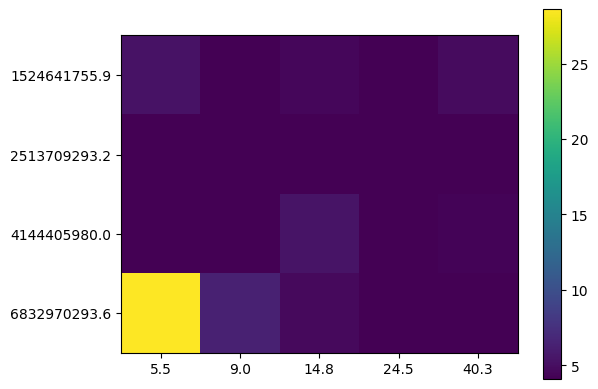

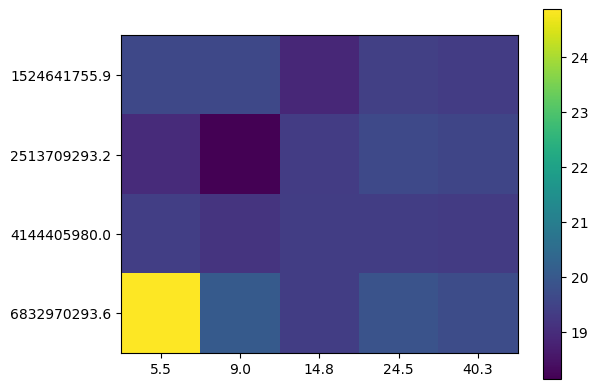

CPU times: user 4d 12h 25min, sys: 1h 21min 37s, total: 4d 13h 46min 38s
Wall time: 1d 13h 28min 50s


In [14]:
%%time
reff_2d = []
density_2d = []
count = 0
for i in uncertainties:
    reff_1d = []
    density_1d = []
    for j in scales:
        count += 1
        print(str(count) + " out of " + str(len(uncertainties)*len(scales)))
        print("------uncertainty", i, "scale", j, "-------")
        reff, density = retrieve(i, j)
        reff_1d.append(reff)
        density_1d.append(density)
    reff_2d.append(reff_1d)
    density_2d.append(density_1d)

rounded_uncertainties = np.round(uncertainties, 1)
rounded_scales = np.round(scales, 1)
img = py.imshow(reff_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()

img = py.imshow(density_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()


In [16]:
reff_2d[1][0]
uncertainties[3]
# scales[2]

6832970293.64281